In [1]:
%matplotlib inline

from __future__ import division, print_function

import glob as glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import optimize

sns.set_style('white')

/Users/julialeonard/anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.0.1 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/Users/julialeonard/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## What is the function of the relationship between effort, difficulty, and skill? 

### This is from what Max KW and I had in a previous model. Basically assuming p(getting reward) = E*Skill/ diff with some free parameters. Put in an exponential function

*effort is definitely a multiplier


In [81]:
#free parameters for now
B=6
A=60 # 40 # 60

#def prob_reward(e,diff,skill):
#    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) 

def prob_reward(e,diff,skill):
    return 1/(1 + A * np.exp(-(e * skill / diff) * B)) 



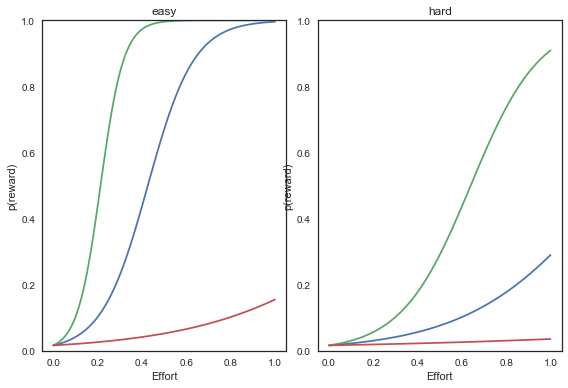

In [82]:
unskilled = .4
skilled = .8
easy = .25
hard = .75
es=np.linspace(0,1,100)
p0 = [prob_reward(e,easy,unskilled) for e in es]
p1 = [prob_reward(e,easy,skilled) for e in es]
p2 = [prob_reward(e,easy,kid) for e in es]

plt.subplot(1,2,1)
plt.plot(es,p0, es, p1, es, p2)
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('easy')

p0 = [prob_reward(e,hard,unskilled) for e in es]
p1 = [prob_reward(e,hard,skilled) for e in es]
p2 = [prob_reward(e,hard,kid) for e in es]
plt.subplot(1,2,2)
plt.plot(es,p0, es, p1, es, p2)
plt.tight_layout()
plt.ylim([0,1])
plt.xlabel('Effort') ; plt.ylabel('p(reward)'); plt.title('hard')

### Write function that incorporates utility so that you can extract skill based on effort and difficulty

In [83]:
##free parameters
REWARD = 1
COST = 0.5

def get_skill(reward, cost, diff, effort):
    Us=list()
    es = np.linspace(0, 1, 100) 
    for i in es:
        U=reward*prob_reward(effort, diff, i)-cost*effort #utility function
        Us.append(U)
    return es[np.argmax(Us)], Us, es  #return argmax of utility, and utilities 

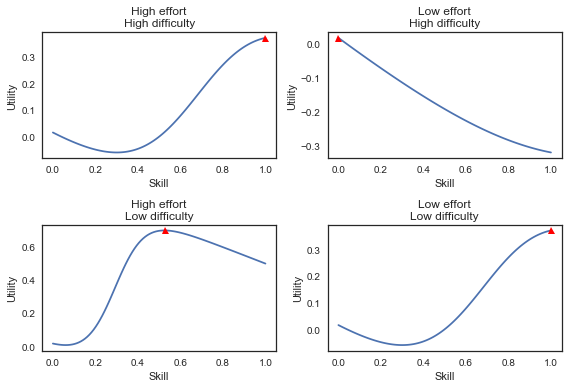

In [84]:
high_eff = .7
low_eff = .3
easy = .3
hard = .7

plt.subplot(2,2,1)
effort,Us,es=get_effort(REWARD,COST,hard,high_eff) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Skill')
plt.ylabel('Utility')
plt.title('High effort\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,2)
effort,Us,es=get_effort(REWARD,COST,hard,low_eff) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Skill')
plt.ylabel('Utility')
plt.title('Low effort\nHigh difficulty')
plt.tight_layout()

plt.subplot(2,2,3)
effort,Us,es=get_effort(REWARD,COST,easy,high_eff) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Skill')
plt.ylabel('Utility')
plt.title('High effort\nLow difficulty')
plt.tight_layout()

plt.subplot(2,2,4)
effort,Us,es=get_effort(REWARD,COST,easy,low_eff) 
plt.plot(es,Us)
plt.plot(effort,max(Us),'r^')
plt.xlabel('Skill')
plt.ylabel('Utility')
plt.title('Low effort\nLow difficulty')
plt.tight_layout()

### Problem with utility functions: low effort high diff should be the opposite - as in high skill only because only highly skilled agents can do a hard task with little effort. And for low effort, low difficulty, the function should be much flatter since there is a lot of uncertainty as to what their skill should be - but it should fall somewhere in the middle, not the far right

In [75]:
diff = .4
eff = .2
reward = 1
cost = .5
skill,_,_= get_effort(reward, cost, diff, eff)
skill

0.0

In [72]:
high_eff_high_diff,_,_= get_effort(reward, cost, .7, .7)
low_eff_high_diff,_,_= get_effort(reward, cost, .7,.2)
high_eff_low_diff,_,_= get_effort(reward, cost, .2, .7)
low_eff_low_diff,_,_= get_effort(reward, cost, .2, .2)


print (high_eff_high_diff) #skilled
print (low_eff_high_diff) #should BE VERY SKILLED - but instead get least skilled
print (high_eff_low_diff) #should be LEAST SKILLED
print (low_eff_low_diff) #unclear on skill.

1.0
0.0
0.373737373737
1.0


## Create priors for skill across two conditions in Exp 1 (different effort, same high difficulty)

In [32]:
threshold = .5
#MAKE INTO DIC
sampled_skill_high_hard = list()
sampled_skill_low_hard = list()
sampled_skill_high_easy  = list()
sampled_skill_low_easy = list()
diff_samp=list()
skill_samp=list()
effort_samp=list()
for _ in xrange(N_samples):
    effort = np.random.beta(.5,.5) #effort is a beta function (high or low)
    diff = np.random.beta(.5,.5) #difficulty is a beta function (high or low)
    skill,_,_ = get_effort(REWARD, COST, diff, effort) 
    high_effort = effort > threshold
    high_diff = diff > threshold
    if high_diff and high_effort: 
        sampled_skill_high_hard.append(skill)
    elif high_diff and not high_effort: 
        sampled_skill_low_hard.append(skill)
    elif not high_diff and not high_effort: 
        sampled_skill_low_easy.append(skill)
    elif not high_diff and high_effort: 
        sampled_skill_high_easy.append(skill)


df = pd.DataFrame([{'cond': 'High diff \n High eff', 'post': s} for s in sampled_skill_high_hard] +  
                  [{'cond': 'High diff \n Low eff', 'post': s} for s in sampled_skill_low_hard] +      
                  [{'cond': 'Low diff \n High eff', 'post': s} for s in sampled_skill_high_easy] +      
                  [{'cond': 'Low diff \n Low eff', 'post': s} for s in sampled_skill_low_easy])     



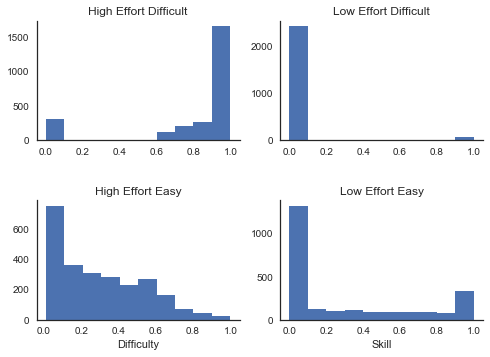

In [33]:
fig = plt.figure()
fig.subplots_adjust(hspace=.5)
plt.subplot(2,2,1)
plt.hist(sampled_skill_high_hard)
plt.title('High Effort Difficult')
plt.subplot(2,2,2)
plt.hist(sampled_skill_low_hard)
plt.title('Low Effort Difficult')
plt.subplot(2,2,3)
plt.hist(sampled_skill_high_easy)
plt.title('High Effort Easy')
plt.xlabel('Difficulty')
plt.subplot(2,2,4)
plt.hist(sampled_skill_low_easy)
plt.title('Low Effort Easy')
plt.xlabel('Skill')
sns.despine()

In [53]:
def get_your_skill(reward, cost):  #model for planning. Takes in diff, skill, and cost -returns effort
    sampled_skill=list()
    sampled_eff = list()
    sampled_diff = list()
    for i in xrange(N_samples): 
        effort = np.random.beta(.5,.5) #effort is a beta function (high or low)
        diff = np.random.beta(.5,.5)
        skill,_,_= get_effort(reward, cost, diff, effort) #noise on d
        sampled_skill.append(skill)
        sampled_eff.append(effort)
        sampled_diff.append(diff)
    return sampled_skill, sampled_eff, sampled_diff



In [55]:
skill,effort,diff = get_your_skill(REWARD,COST)

In [70]:
df = []
for s, e, d in zip(skill, effort, diff):
    df.append({
            'skill':s,
            'effort':e,
            'diff':d,
        })
df = pd.DataFrame(df)
df.head()

,diff,effort,skill
0,0.973599,0.001144,0.000000
1,0.068062,0.450687,0.212121
2,0.916737,0.694613,1.000000
3,0.466826,0.344435,1.000000
4,0.009472,0.796552,0.020202


In [ ]:
sns.lmplot(x="skill", y="effort",scatter=False, ci=None, data=df, lowess=True)
plt.ylim([0,.8])
plt.xlim([.10,.55])